In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate

# import all the models from models module
from models import CNN3D

In [8]:
# Current Path
os.getcwd()

'c:\\Users\\ahmed\\Documents\\DeepLearningSummer\\Multimodal-Deep-Regression\\notebooks'

In [9]:
# preprocessing data
# (Batch, Channels, Frames, Height, Width)
# B x C x D x H x W

In [10]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [11]:
x_file_path = "../data/gen_data_x.pt"
y_file_path = "../data/gen_data_y.pt"

x_data = []
y_data = []

# Save the x & y tensors
with open(x_file_path, 'wb') as x_file, open(y_file_path, 'wb') as y_file:
    for _ in tqdm(range(10)):
        x = torch.randint(0, 255, (3, 20, 1024, 576))#, dtype=torch.uint8)
        y = x.to(torch.float32).mean() * 100
        x_data.append(x.tolist())
        y_data.append(y)
    
    x_data = torch.tensor(x_data)
    y_data = torch.tensor(y_data)
    # add a dim
    y_data = y_data.unsqueeze(1)
    
    torch.save(x_data, x_file)
    torch.save(y_data, y_file)

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [12]:
x_file_path = "../data/gen_data_x.pt"
y_file_path = "../data/gen_data_y.pt"

# Load the tensors
x_data = torch.load(x_file_path)
y_data = torch.load(y_file_path)

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train.size())
print(x_val.size())
print(y_train.size())
print(y_val.size())

torch.Size([8, 3, 20, 1024, 576])
torch.Size([2, 3, 20, 1024, 576])
torch.Size([8, 1])
torch.Size([2, 1])


In [13]:
# Create Batches with DataLoaders
batch_size = 2
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model = CNN3D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=0.01)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 10
    if ((epoch+1) % num == 0) or epoch == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

Total parameters: 23594273
Epoch 1/100, Train_Loss: 3652969531936.00, Avg: 913242382984.00; Val_Loss: 1279369936896.00, Avg: 1279369936896.00


KeyboardInterrupt: 

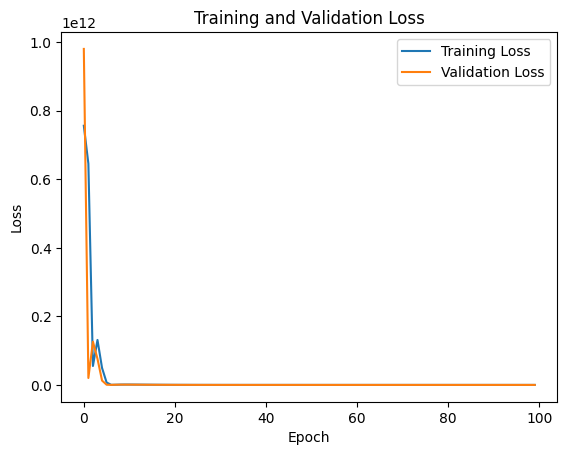

In [9]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

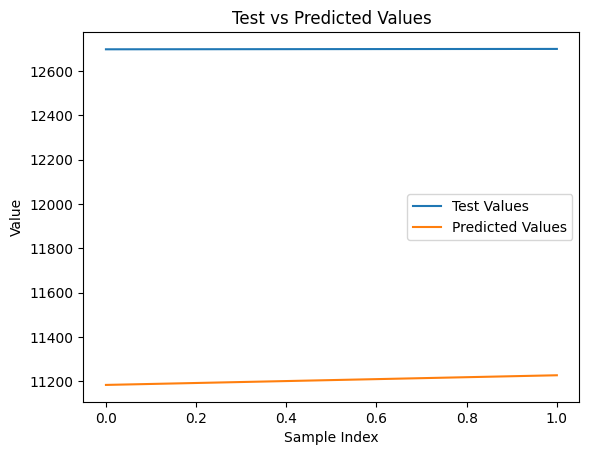

In [11]:
import matplotlib.pyplot as plt

plt.plot(val_values, label='Test Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [12]:
val_values, predicted_values

([[12698.20703125], [12699.92578125]], [[11183.443359375], [11227.0283203125]])